### <font color='indigo'>1) Import the Required Packages and Load the Dataset

In [3]:
#!pip install xgboost
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [4]:
df = pd.read_csv("CR2_Data_Processed.csv", header=0, skiprows=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   age                                    45528 non-null  float64
 1   no_of_children                         45528 non-null  float64
 2   net_yearly_income                      45528 non-null  float64
 3   no_of_days_employed                    45528 non-null  float64
 4   total_family_members                   45528 non-null  float64
 5   migrant_worker                         45528 non-null  float64
 6   yearly_debt_payments                   45528 non-null  float64
 7   credit_limit                           45528 non-null  float64
 8   credit_limit_used(%)                   45528 non-null  float64
 9   credit_score                           45528 non-null  float64
 10  prev_defaults                          45528 non-null  float64
 11  de

In [5]:
df.head()

,age,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,...,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Unknown,occupation_type_Waiters/barmen staff
0,46.0,0.0,107934.04,612.0,1.0,1.0,33070.28,18690.93,73.0,544.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29.0,0.0,109862.62,2771.0,2.0,0.0,15329.53,37745.19,52.0,857.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,37.0,0.0,230153.17,204.0,2.0,0.0,48416.60,41598.36,43.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39.0,0.0,122325.82,11941.0,2.0,0.0,22574.36,32627.76,20.0,754.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46.0,0.0,387286.00,1459.0,1.0,0.0,38282.95,52950.64,75.0,927.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### <font color='indigo'>2) Data Preparation for the Model

#### Predictors-Target Split

In [6]:
X = df.drop(["credit_card_default"], axis=1) #predictors
Y = df[["credit_card_default"]] #target

#### Train-Valid-Test Split

* Splitting the whole dataset into three sets: train, validation, and test with ratios of 80%, 10%, and 10% respectively.

In [7]:
train_size=0.8
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8, random_state=777)

test_size = 0.5
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=777)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(36422, 38)
(36422, 1)
(4553, 38)
(4553, 1)
(4553, 38)
(4553, 1)


(None, None)

#### Undersampling

In [8]:
X_Y_train = pd.concat([X_train.reset_index(drop = True),Y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_Y_train['credit_card_default'].value_counts()
nondefaults = X_Y_train[X_Y_train['credit_card_default'] == 0]
defaults = X_Y_train[X_Y_train['credit_card_default'] == 1]

nondefaults_under = nondefaults.sample(count_default)
X_Y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),defaults.reset_index(drop = True)], axis=0)

In [10]:
X_train = X_Y_train_under.drop(["credit_card_default"], axis=1) #predictors
Y_train = X_Y_train_under[["credit_card_default"]] #target

### <font color='indigo'>3) Model Building

In [11]:
model_xgb = xgb.XGBClassifier(learning_rate=0.1,
                             max_depth=5,
                             n_estimators=5000,
                             subsample=0.5,
                             colsample_bytree=0.5,
                             eval_metric="auc",
                             verbosity=1)

eval_set = [(X_valid, Y_valid)]

# Fitting the model
model_xgb.fit(X_train,
              np.ravel(Y_train),
              early_stopping_rounds=10,
              eval_set=eval_set,
              verbose=True)

[0]	validation_0-auc:0.99475
[1]	validation_0-auc:0.99337
[2]	validation_0-auc:0.99270
[3]	validation_0-auc:0.99321
[4]	validation_0-auc:0.99274
[5]	validation_0-auc:0.99406
[6]	validation_0-auc:0.99467
[7]	validation_0-auc:0.99451
[8]	validation_0-auc:0.99452
[9]	validation_0-auc:0.99458
[10]	validation_0-auc:0.99496
[11]	validation_0-auc:0.99489
[12]	validation_0-auc:0.99488
[13]	validation_0-auc:0.99490
[14]	validation_0-auc:0.99493
[15]	validation_0-auc:0.99488
[16]	validation_0-auc:0.99481
[17]	validation_0-auc:0.99491
[18]	validation_0-auc:0.99491
[19]	validation_0-auc:0.99488
[20]	validation_0-auc:0.99488


C:\Users\Dell\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

### <font color='indigo'>4) Model Performance Indicators


In [12]:
Y_train_pred = model_xgb.predict_proba(X_train)[:,1]
Y_valid_pred = model_xgb.predict_proba(X_valid)[:,1]
Y_test_pred = model_xgb.predict_proba(X_test)[:,1]

In [13]:
print(f"AUC train: {roc_auc_score(Y_train, Y_train_pred):1f}")
print(f"AUC valid: {roc_auc_score(Y_valid, Y_valid_pred):1f}")

AUC train: 0.996675
AUC valid: 0.994964


Text(0.5, 23.52222222222222, 'Predicted label')

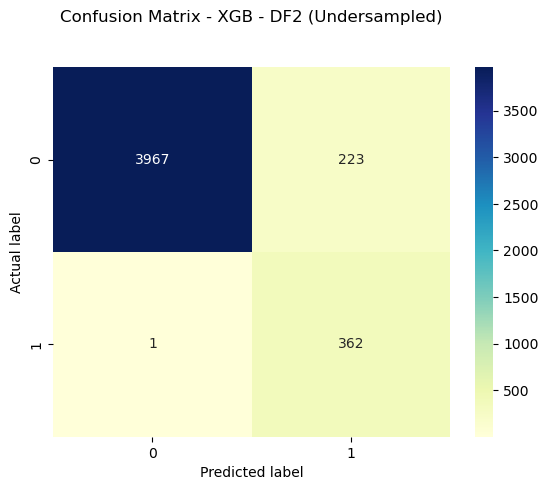

In [14]:
Y_pred_cat_1 = model_xgb.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred_cat_1)
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion Matrix - XGB - DF2 (Undersampled)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

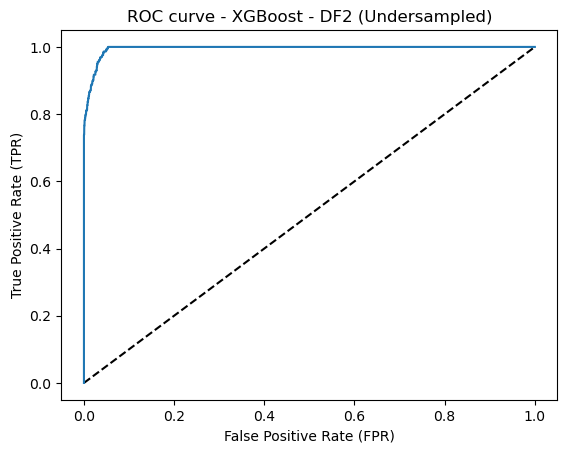

In [15]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - XGBoost - DF2 (Undersampled)')
plt.show()

In [16]:
print(f"AUC test: {roc_auc_score(Y_test, Y_test_pred):1f}")

AUC test: 0.995478


### <font color='indigo'>5) Hyperparameter Tuning

In [17]:
learning_rate_vals = [0.05, 0.1, 0.15, 0.25, 0.3]
max_dept_vals = [3, 4, 5, 6, 8, 10, 12, 15]
n_estimators_vals = [3000, 5000, 7000]

parameters = {"learning_rate": learning_rate_vals,
             "max_depth": max_dept_vals,
             "n_estimators": n_estimators_vals}

random_search = RandomizedSearchCV(model_xgb, param_distributions=parameters, n_iter=5, scoring="roc_auc",
                                  n_jobs=-1, cv=5, verbose=3)

random_search

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.5,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=0,
                                           gpu_id=-1, grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0....
                                           max_delta_step=0, max_depth=5,
                                           max_leaves=0, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=5000, n_jobs=0,
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=0, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.25,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'n_estimators': [3000, 5000, 7000]},
                   scoring='roc_auc', verbose=3)

### <font color='indigo'>6) Final Model

In [18]:
model_xgb_final = xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=5000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0)

eval_set = [(X_valid, Y_valid)]

model_xgb_final.fit(X_train,
              np.ravel(Y_train),
              early_stopping_rounds=20,
              eval_set=eval_set,
              verbose=True)

[0]	validation_0-auc:0.99400
[1]	validation_0-auc:0.99219
[2]	validation_0-auc:0.99429
[3]	validation_0-auc:0.99458
[4]	validation_0-auc:0.99429
[5]	validation_0-auc:0.99436
[6]	validation_0-auc:0.99435
[7]	validation_0-auc:0.99451
[8]	validation_0-auc:0.99432
[9]	validation_0-auc:0.99463
[10]	validation_0-auc:0.99486
[11]	validation_0-auc:0.99490
[12]	validation_0-auc:0.99492
[13]	validation_0-auc:0.99494
[14]	validation_0-auc:0.99494
[15]	validation_0-auc:0.99497
[16]	validation_0-auc:0.99496
[17]	validation_0-auc:0.99497
[18]	validation_0-auc:0.99508
[19]	validation_0-auc:0.99511
[20]	validation_0-auc:0.99522
[21]	validation_0-auc:0.99525
[22]	validation_0-auc:0.99518
[23]	validation_0-auc:0.99522
[24]	validation_0-auc:0.99526
[25]	validation_0-auc:0.99525
[26]	validation_0-auc:0.99529
[27]	validation_0-auc:0.99528
[28]	validation_0-auc:0.99529
[29]	validation_0-auc:0.99530
[30]	validation_0-auc:0.99527
[31]	validation_0-auc:0.99525
[32]	validation_0-auc:0.99526


C:\Users\Dell\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.99526
[34]	validation_0-auc:0.99529
[35]	validation_0-auc:0.99527
[36]	validation_0-auc:0.99527
[37]	validation_0-auc:0.99527
[38]	validation_0-auc:0.99527
[39]	validation_0-auc:0.99532
[40]	validation_0-auc:0.99534
[41]	validation_0-auc:0.99532
[42]	validation_0-auc:0.99533
[43]	validation_0-auc:0.99534
[44]	validation_0-auc:0.99534
[45]	validation_0-auc:0.99532
[46]	validation_0-auc:0.99530
[47]	validation_0-auc:0.99527
[48]	validation_0-auc:0.99529
[49]	validation_0-auc:0.99529
[50]	validation_0-auc:0.99533
[51]	validation_0-auc:0.99533
[52]	validation_0-auc:0.99535
[53]	validation_0-auc:0.99533
[54]	validation_0-auc:0.99532
[55]	validation_0-auc:0.99533
[56]	validation_0-auc:0.99533
[57]	validation_0-auc:0.99536
[58]	validation_0-auc:0.99539
[59]	validation_0-auc:0.99539
[60]	validation_0-auc:0.99541
[61]	validation_0-auc:0.99542
[62]	validation_0-auc:0.99546
[63]	validation_0-auc:0.99543
[64]	validation_0-auc:0.99541
[65]	validation_0-auc:0.99542
[66]	valid

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [19]:
Y_train_pred_2 = model_xgb_final.predict_proba(X_train)[:,1]
Y_valid_pred_2 = model_xgb_final.predict_proba(X_valid)[:,1]
Y_test_pred_2 = model_xgb_final.predict_proba(X_test)[:,1]

In [20]:
print(f"AUC train: {roc_auc_score(Y_train, Y_train_pred_2):1f}")
print(f"AUC valid: {roc_auc_score(Y_valid, Y_valid_pred_2):1f}")

AUC train: 0.998906
AUC valid: 0.995464


In [21]:
model_pred_prob = model_xgb_final.predict_proba(X_test)
model_pred_label = model_xgb_final.predict(X_test)

target_names = ['Non-Default', 'Default']
print(classification_report(Y_test, model_pred_label, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       1.00      0.95      0.97      4190
     Default       0.62      1.00      0.76       363

    accuracy                           0.95      4553
   macro avg       0.81      0.97      0.87      4553
weighted avg       0.97      0.95      0.96      4553



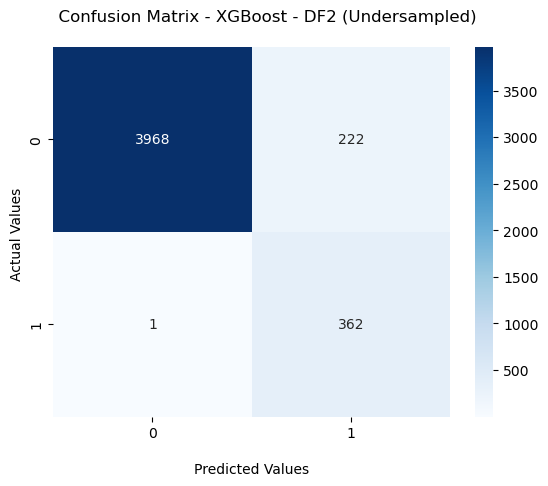

In [22]:
cm_final_model = confusion_matrix(Y_test, model_pred_label)
ax = sns.heatmap(cm_final_model, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt="d")
ax.set_title('      Confusion Matrix - XGBoost - DF2 (Undersampled)\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

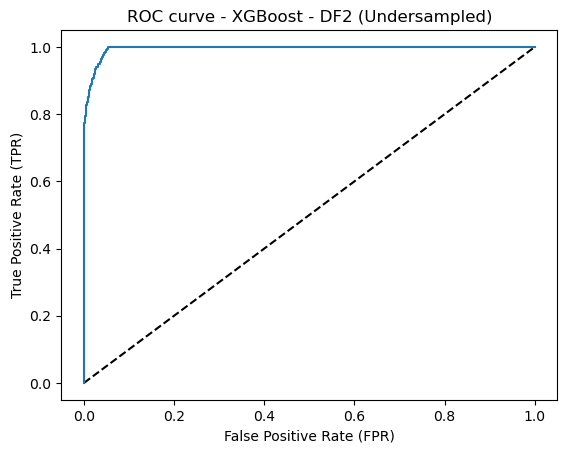

In [26]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_pred_2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - XGBoost - DF2 (Undersampled)')
plt.show()

In [27]:
print(f"AUC test: {roc_auc_score(Y_test, Y_test_pred_2):1f}")

AUC test: 0.995516


#### Feature Selection in Xgboost

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

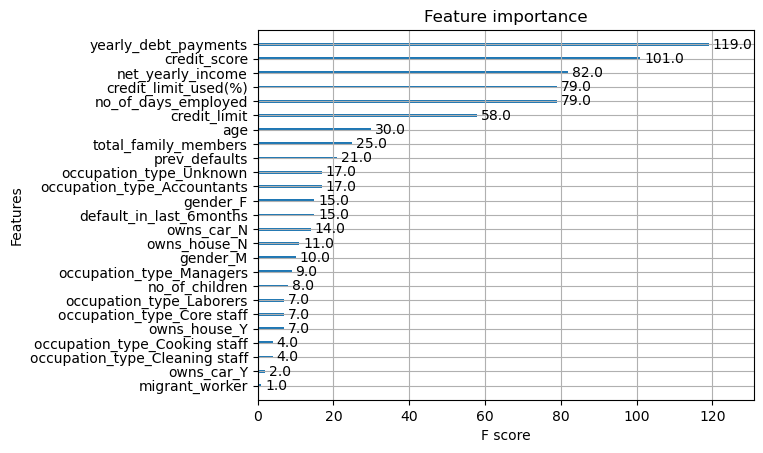

In [28]:
xgb.plot_importance(model_xgb_final, importance_type="weight")